In [ ]:

# Import required libraries
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader

X_train_HR = np.load('./A_HR_train.npy').astype(np.float32) 
X_train_LR = np.load('./A_LR_train.npy').astype(np.float32)
X_train_HR = torch.Tensor(X_train_HR)
X_train_LR = torch.Tensor(X_train_LR)
print(X_train_HR.shape)
print(X_train_LR.shape)


torch.Size([8100, 1, 150, 150])
torch.Size([8100, 1, 75, 75])


In [18]:
X_val_HR = np.load('./A_HR_val.npy').astype(np.float32)
X_val_LR = np.load('./A_LR_val.npy').astype(np.float32)
X_val_HR = torch.Tensor(X_val_HR)
X_val_LR = torch.Tensor(X_val_LR)
print(X_val_HR.shape)
print(X_val_LR.shape)

torch.Size([1000, 1, 150, 150])
torch.Size([1000, 1, 75, 75])


In [19]:
X_test_HR = np.load('./A_HR_test.npy').astype(np.float32)
X_test_LR = np.load('./A_LR_test.npy').astype(np.float32)
print(X_test_HR.shape)
print(X_test_LR.shape)

(900, 1, 150, 150)
(900, 1, 75, 75)


In [20]:
batch_size = 20
train_dataset = TensorDataset(X_train_LR, X_train_HR)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = TensorDataset(X_val_LR, X_val_HR)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)



In [21]:

class Conv(nn.Module):
  def __init__(self, in_c, out_c, **kwargs):
      super().__init__()
      self.cnn = nn.Conv2d(in_c, out_c, **kwargs)
      self.actication = nn.PReLU(num_parameters=out_c)

  def forward(self, x):
      x = self.cnn(x)
      x = self.actication(x)
      return x

class Upsample(nn.Module):
  def __init__(self, in_c, scale_factor):
      super().__init__()
      self.conv = nn.Conv2d(in_c, in_c * scale_factor ** 2, kernel_size=3, stride=1, padding=1)
      self.pixel_shuffle = nn.PixelShuffle(scale_factor)
      self.activation = nn.PReLU(num_parameters=in_c)

  def forward(self, x):
      x = self.conv(x)
      x = self.pixel_shuffle(x)
      x = self.activation(x)
      return x

class RBlock(nn.Module):
  def __init__(self, in_c):
      super().__init__()
      self.b1 = Conv(in_c, in_c, kernel_size=3, stride=1, padding=1)
      self.b2 = Conv(in_c, in_c, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
      b1_output = self.b1(x)
      b2_output = self.b2(b1_output)
      return b2_output + x

class Generator(nn.Module):
  def __init__(self, in_c=1, out_c=64, no_blocks=18):
      super().__init__()
      self.first_conv = Conv(in_c, out_c, kernel_size=9, stride=1, padding=4)
      res_blocks = []
      for _ in range(no_blocks):
          res_blocks.append(RBlock(64))
      self.res_blocks = nn.Sequential(*res_blocks)
      self.conv1 = Conv(out_c, out_c, kernel_size=3, stride=1, padding=1)

      self.upsampling = Upsample(out_c, scale_factor=2)
      self.last_conv = nn.Conv2d(out_c, in_c, kernel_size=3, stride=1, padding=1)

  def forward(self,x):
      first_conv = self.first_conv(x)
      x = self.res_blocks(first_conv)
      x = self.conv1(x) + first_conv
      x = self.upsampling(x)
      x = self.last_conv(x)
      return x
     
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Generator().to(device)
model = model.to(device)



In [22]:
# Set the loss criterion and optimizer
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# Set the number of training epochs and learning rate scheduler
n_epochs = 50
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 2e-4, epochs=n_epochs, steps_per_epoch=X_train_HR.shape[0])

In [ ]:
import sklearn
def evaluate(model, dataloader):
    with torch.no_grad():
        total_loss = 0  
        for data in tqdm(dataloader):
            lr = data[0]
            hr = data[1]
            lr = lr.to(device)
            hr = hr.to(device)

            # predict
            pred_hr = model(lr)

            loss = criteria(pred_hr,hr)
            total_loss += loss.item()
    return total_loss/len(dataloader.dataset)
def train(model, dataloader):
    train_loss=0
    for data in dataloader:

        # Fetch HR, LR data and pass to device
        lr = data[0]
        hr = data[1]
        lr = lr.to(device)
        hr = hr.to(device)

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(lr)
        # Calculate the loss
        loss = criteria(outputs, hr)

        # Reset the gradients
        optimizer.zero_grad()
        # Perform a backward pass (backpropagation)
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Update the learning rate
        scheduler.step()

         # Update the training loss
        train_loss += (loss.item()*hr.size(0))
    return train_loss / len(dataloader.dataset)
        

In [27]:
# Training loop
train_loss_array = []
val_loss_array = []
best_val_loss = float('inf')
for epoch in tqdm(range(1, n_epochs+1)):
    train_loss =train(model, train_dataloader)
    train_loss_array.append(train_loss)

    val_loss=evaluate(model,val_dataloader)
    val_loss_array.append(val_loss)

    print(f"Epoch {epoch}/{n_epochs}, train Loss: {train_loss }, val Loss: {val_loss}")    
    # Save model and training loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './Model/SRResNet.pth')
    best = torch.load('./Model/SRResNet.pth')
    model.load_state_dict(best)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, train Loss: 0.0002076558438187212, val Loss: 7.833921146811918e-06


/tmp/ipykernel_2383/3160281612.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best = torch.load('./Model/SRResNet.pth')


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/50, train Loss: 0.00013337356732212537, val Loss: 5.7933712596422995e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/50, train Loss: 0.00010465252285759988, val Loss: 4.816728454898112e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/50, train Loss: 9.082169394169785e-05, val Loss: 4.3537294986890626e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/50, train Loss: 8.436398513120726e-05, val Loss: 4.140011296840384e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/50, train Loss: 8.125285916950232e-05, val Loss: 4.027809358376544e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/50, train Loss: 7.943432121666976e-05, val Loss: 3.95499168371316e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/50, train Loss: 7.814212903785692e-05, val Loss: 3.897525413776748e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/50, train Loss: 7.712542047770119e-05, val Loss: 3.851196022878867e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50, train Loss: 7.622345080484211e-05, val Loss: 3.8078888537711465e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/50, train Loss: 7.53846848606316e-05, val Loss: 3.771060706640128e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/50, train Loss: 7.453738348156121e-05, val Loss: 3.7220417216303756e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/50, train Loss: 7.370263321920195e-05, val Loss: 3.6816427527810445e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/50, train Loss: 7.278624752085127e-05, val Loss: 3.6336061457404868e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/50, train Loss: 7.184522641811198e-05, val Loss: 3.5833453293889762e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/50, train Loss: 7.079934635211104e-05, val Loss: 3.526055232214276e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/50, train Loss: 6.965914244237528e-05, val Loss: 3.468355105724186e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/50, train Loss: 6.841634607508801e-05, val Loss: 3.399334542336874e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/50, train Loss: 6.704703853666828e-05, val Loss: 3.326651691168081e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50, train Loss: 6.560973580897912e-05, val Loss: 3.25419508953928e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/50, train Loss: 6.426985144369408e-05, val Loss: 3.1929070391925054e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/50, train Loss: 6.331089230284475e-05, val Loss: 3.1667067960370333e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23/50, train Loss: 6.218984390552914e-05, val Loss: 3.107234682829585e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24/50, train Loss: 6.166948626259124e-05, val Loss: 3.0807780422037465e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25/50, train Loss: 6.137245934187825e-05, val Loss: 3.0590394999308046e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/50, train Loss: 6.075617946205764e-05, val Loss: 3.0463780822174156e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27/50, train Loss: 6.060711125933772e-05, val Loss: 3.0380738935491537e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28/50, train Loss: 6.051993630445608e-05, val Loss: 3.0347047904797363e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29/50, train Loss: 6.030436479817087e-05, val Loss: 3.0371862194442654e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30/50, train Loss: 6.035957009356216e-05, val Loss: 3.020308427949203e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31/50, train Loss: 6.017714704172743e-05, val Loss: 3.0151070168358273e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32/50, train Loss: 6.013723727341534e-05, val Loss: 3.0105710284260567e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33/50, train Loss: 6.008959968357324e-05, val Loss: 3.014309178979602e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34/50, train Loss: 6.0053273566918057e-05, val Loss: 3.0071661894908173e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35/50, train Loss: 5.994655765351598e-05, val Loss: 3.0041496829653624e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36/50, train Loss: 5.987145824618005e-05, val Loss: 2.9981523512105923e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37/50, train Loss: 6.0071943539416094e-05, val Loss: 2.99730948972865e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38/50, train Loss: 5.967332474904618e-05, val Loss: 2.9963902052259072e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39/50, train Loss: 5.978583076172566e-05, val Loss: 2.9926929273642598e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 40/50, train Loss: 5.966209825185806e-05, val Loss: 2.9902419919380917e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 41/50, train Loss: 5.977767975792507e-05, val Loss: 2.987288040458225e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 42/50, train Loss: 5.970048509038019e-05, val Loss: 2.9860983122489416e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 43/50, train Loss: 5.9524760653414294e-05, val Loss: 2.983865637361305e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 44/50, train Loss: 5.979239623555281e-05, val Loss: 2.9863896270398983e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 45/50, train Loss: 5.962461636280986e-05, val Loss: 2.9819876071996986e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 46/50, train Loss: 5.9665579851472426e-05, val Loss: 2.9805753329128493e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 47/50, train Loss: 5.95360184012895e-05, val Loss: 3.096896696661133e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 48/50, train Loss: 5.983889729386759e-05, val Loss: 2.9810998566972555e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49/50, train Loss: 5.944235601396311e-05, val Loss: 2.9956062280689365e-06


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50/50, train Loss: 5.9694383229793014e-05, val Loss: 2.985447605169611e-06


In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm

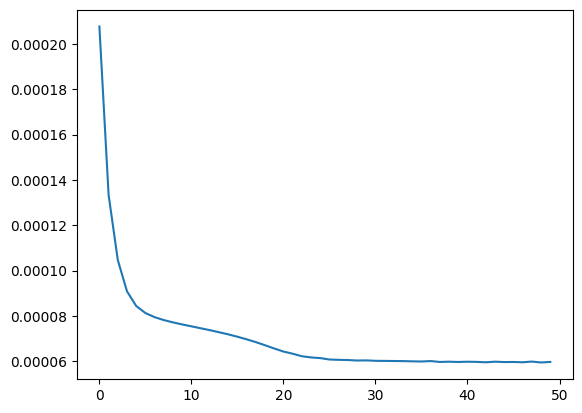

In [29]:
plt.plot(train_loss_array)

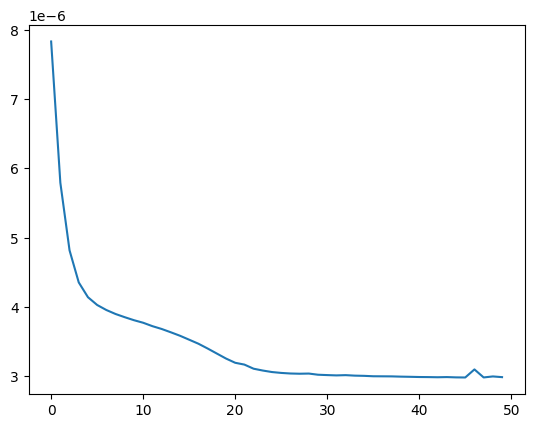

In [30]:
plt.plot(val_loss_array)

In [31]:
out = []
for i in tqdm(range(X_test_LR.shape[0])):
    data = torch.from_numpy(X_test_LR[i].reshape(1,1,75,75))
    data = data.to(device)
    recon = model(data)
    out.append(recon.cpu().detach().numpy().reshape(1,150,150))
test_pred = np.asarray(out).astype(np.float32)
print(test_pred.shape)

print("Metrics:")
criteria = nn.MSELoss()
losses = []
Ssim = []
Psnr = []
for i in range(X_test_LR.shape[0]):
    losses.append(criteria(torch.from_numpy(test_pred[i]), torch.from_numpy(X_test_HR[i])))
    Ssim.append(ssim(X_test_HR[i][0], test_pred[i][0], data_range=test_pred[i][0].max() -test_pred[i][0].min()))
    Psnr.append(psnr(X_test_HR[i][0], test_pred[i][0]))
print("Average MSE super resolution samples: " + str('%.5f'%np.average(losses)))
print("Average SSIM super resolution samples: " + str('%.5f'%np.average(Ssim)))
print("Average PSNR super resolution samples: " + str('%.5f'%np.average(Psnr)))


  0%|          | 0/900 [00:00<?, ?it/s]

(900, 1, 150, 150)
Metrics:
Average MSE super resolution samples: 0.00006
Average SSIM super resolution samples: 0.97646
Average PSNR super resolution samples: 42.26694


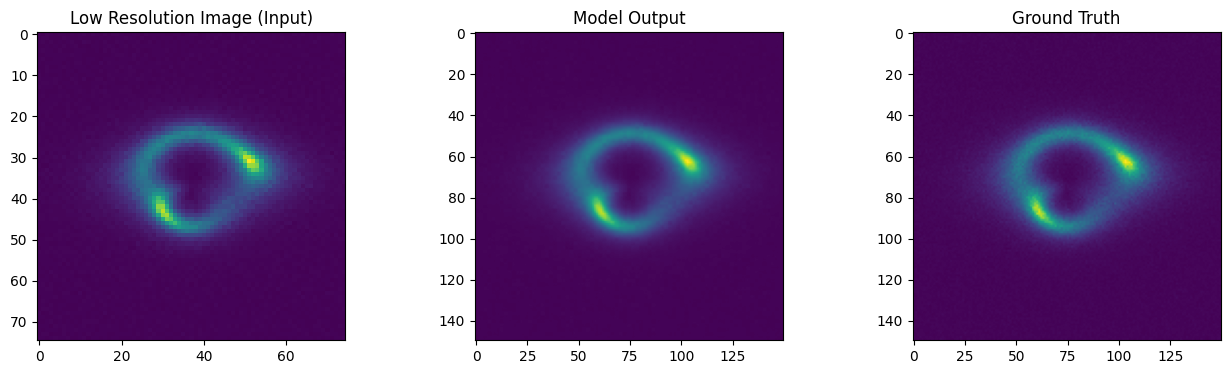

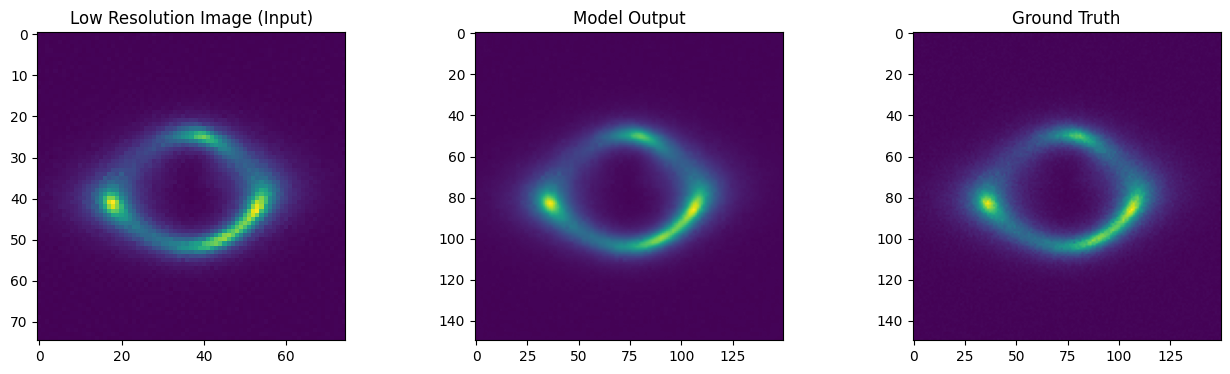

In [32]:
for i in range(2):
  f, axarr = plt.subplots(nrows=1,ncols=3,figsize=(16,4))
  plt.sca(axarr[0]); 
  plt.imshow(X_test_LR[i][0]); plt.title('Low Resolution Image (Input)')
  plt.sca(axarr[1]); 
  plt.imshow(test_pred[i][0]); plt.title('Model Output')
  plt.sca(axarr[2]); 
  plt.imshow(X_test_HR[i][0]); plt.title('Ground Truth')
  plt.savefig('./Result/Sample' + str(i+1) + '.png', format='png', dpi=300)
